# Necessary packages

In [83]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple, List
from pandas_profiling import ProfileReport
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

# Exploratory Analysis

In [2]:
df = pd.read_csv("dataset/labels.csv")
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Continuing with the exploratory analysis, an image of each white blood cell (WBC) type was plotted below. This allowed for an initial understanding of what differences exist between the 5 different types.

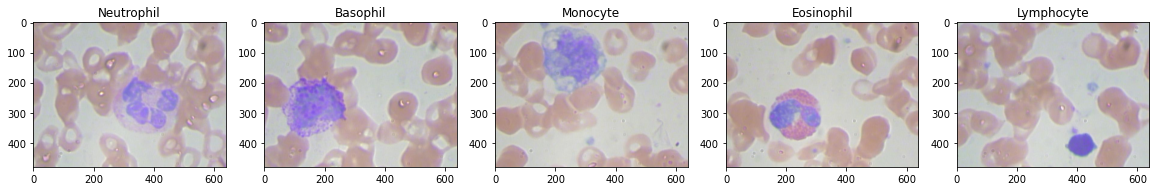

In [3]:
neutrophil = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00000.jpg"), 
    cv2.COLOR_BGR2RGB,
)
basophil = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00008.jpg"), 
    cv2.COLOR_BGR2RGB,
)
monocyte = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00015.jpg"),
    cv2.COLOR_BGR2RGB,
)
eosinophil = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00017.jpg"),
    cv2.COLOR_BGR2RGB,
)
lymphocyte = cv2.cvtColor(
    cv2.imread("dataset/images/BloodImage_00020.jpg"),
    cv2.COLOR_BGR2RGB,
)
fig, axs = plt.subplots(1, 5, figsize=(20, 7))
axs[0].imshow(neutrophil)
axs[0].title.set_text("Neutrophil")
axs[1].imshow(basophil)
axs[1].title.set_text("Basophil")
axs[2].imshow(monocyte)
axs[2].title.set_text("Monocyte")
axs[3].imshow(eosinophil)
axs[3].title.set_text("Eosinophil")
axs[4].imshow(lymphocyte)
axs[4].title.set_text("Lymphocyte")
plt.show()

# Model

A classifier was built to automatically detect which WBC type was present in a given image.

In [114]:
class Classifier:
    def __init__(self) -> None:
        # Sets the target range for blue in HSV
        self.lb = np.array([105, 90, 160])
        self.ub = np.array([140, 180, 255])
        # Sets the target range for pink in HSV
        self.lp = np.array([134, 60, 59])
        self.up = np.array([165, 120, 202])
        # Bound areas
        self.bigBound = 1000
        self.smallBound = 410

    def __filterNucleus(self) -> np.ndarray:
        """Detects the nucleus of the WBC

        Returns:
            np.ndarray: Mask containing the nucleus of the WBC
        """
        mask = cv2.inRange(self.img, self.lb, self.ub)
        return mask

    def __filterCytoplasm(self) -> np.ndarray:
        """Detects the cytoplasm of the WBC

        Returns:
            np.ndarray: Mask containing the cytoplasm of the WBC
        """
        mask = cv2.inRange(self.img, self.lp, self.up)
        return mask

    def __findNucleus(self, contours: List[np.ndarray]) -> Tuple[List[np.ndarray], float]:
        """Filter out the small contours that are detected as nucleus and calculate total area of big contours

        Args:
            contours (List[np.ndarray]): List of contours detected as nucleus

        Returns:
            Tuple[List[np.ndarray], float]: Filtered list of contours, total area of the filtered contours
        """
        nucleus = []
        area = 0
        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > self.bigBound:
                nucleus += [contour]
                area += contourArea
        return nucleus, area
    
    def __findCytoplasm(self, contours: List[np.ndarray]) -> Tuple[List[np.ndarray], float]:
        """Filter out the small contours that are detected as cytoplasm and calculate total area of big contours

        Args:
            contours (List[np.ndarray]): List of contours detected as cytoplasm

        Returns:
            Tuple[List[np.ndarray], float]: Filtered list of contours, total area of the filtered contours
        """
        cytoplasm = []
        area = 0
        for contour in contours:
            contourArea = cv2.contourArea(contour)
            if contourArea > self.smallBound:
                cytoplasm += [contour]
                area += contourArea
        return cytoplasm, area

    def __findVolume(self, maskNucleus: np.ndarray, maskCytoplasm: np.ndarray) -> float:
        """Calculates volume of a WBC

        Args:
            maskNucleus (np.ndarray): Mask contining areas detected as nucleus
            maskCytoplasm (np.ndarray): Mask containing aread detected as cytoplasm

        Returns:
            float: Estimated colume of the the WBC
        """
        cell = maskNucleus | maskCytoplasm
        h, s, v = cv2.split(self.img)
        maskedHSV = cv2.merge((h, s, cell))
        bgr = cv2.cvtColor(maskedHSV, cv2.COLOR_HSV2BGR)
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        inversedGray = cv2.bitwise_not(gray)
        px_sum = 0
        px_count = 0
        for line in inversedGray:
            for px in line:
                if px < 255:
                    px_sum += px / 255
                    px_count += 1
        r = px_sum / px_count
        vol = (4 / 3) * np.pi * (r ** 3)
        return vol

    def __classify(
        self,
        nucleus: List[np.ndarray],
        cytoplasm: List[np.ndarray],
        isConvex: bool,
        cntApprox: np.ndarray, 
        epsilon: float, 
        totalNucleusArea: float, 
        totalCytoplasmArea: float, 
        cellVolume: float
    ) -> str:
        """Classifies the WBC into one of the possible types

        Args:
            nucleus (List[np.ndarray]): Count of isolated nucleus areas in the image
            cytoplasm (List[np.ndarray]): Count of isolated cytoplasm areas in the image
            isConvex (bool): Identifies the convexity of the largest nucleus area
            cntApprox (np.ndarray): Smoothed contours
            epsilon (float): Perimeter of the largest nucleus contour
            totalNucleusArea (float): Total nucleus area
            totalCytoplasmArea (float): Total cytoplasm area
            cellVolume (float): Estimated volume of the cell

        Returns:
            str: Tag of the class predicted for the WBC
        """
        points = cv2.convexHull(cntApprox, False)
        minCircleRadius = cv2.minEnclosingCircle(points)[1]
        relativeArea = (minCircleRadius * 100) / totalNucleusArea if len(cytoplasm) > 0 else 0
        if len(cytoplasm) == 0 and len(nucleus) > 1:
            return "NEUTROPHIL"
        elif len(cytoplasm) > 0 and len(nucleus) <= 2 and ((relativeArea < 1 and relativeArea > 0.9) or totalCytoplasmArea > 1500):
            return "EOSINOPHIL"
        elif isConvex:
            return "LYMPHOCYTE"
        else:
            if len(points) <= 6 and epsilon > 20:
                return "BASOPHIL"
            else:
                if len(points) < 9 and minCircleRadius > 90:
                    return "MONOCYTE"
                else:
                    if cellVolume < 0.16:
                        return "MONOCYTE"
                    else:
                        return "NEUTROPHIL"
                

    def run(self, imgPath: str) -> str:
        """Runs the classification pipeline

        Args:
            imgPath (str): Relative path of image to be classified

        Returns:
            str: Tag of the class predicted for the image
        """
        try:
            # Read image and convert to HSV
            self.img = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2HSV)
            # Isolate nucleus (blue)
            maskNucleus = self.__filterNucleus()
            # Find contours of isolated big cells
            contours = cv2.findContours(maskNucleus, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            # Filter out the small contours that are detected
            nucleusCount, totalNucleusArea = self.__findNucleus(contours)
            # Isolate small cells (pink cells)
            maskCytoplasm = self.__filterCytoplasm()
            # Find contours of isolated small cells
            contours = cv2.findContours(maskCytoplasm, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            # Filter out the small contours that are detected
            cytoplasmCount, totalCytoplasmArea = self.__findCytoplasm(contours)
            # Calculate cell volume
            cellVolume = self.__findVolume(maskNucleus, maskCytoplasm)
            # Smoothing contours for easier detection o Lymphocytes
            epsilon = cv2.arcLength(nucleusCount[0], True) * 0.02
            cntApprox = cv2.approxPolyDP(nucleusCount[0], epsilon, True)
            # Checking for convexity
            isConvex = cv2.isContourConvex(cntApprox)
            # Classify
            prediction = self.__classify(nucleusCount, cytoplasmCount, isConvex, cntApprox, epsilon, totalNucleusArea, totalCytoplasmArea, cellVolume)
            return prediction
        except Exception as e:
            print(e)
            return "UNMATCH"


# Running the Model

The classifier is now used to predict the type of all the images in the dataset

In [69]:
images = os.listdir("./dataset/images")
predictions = []
classifier = Classifier()
for imageName in images:
    path = "./dataset/images/" + imageName
    predictions += [classifier.run(path)]
df["Predictions"] = predictions
df

,Image,Category,Predictions
0,0,NEUTROPHIL,NEUTROPHIL
1,1,NEUTROPHIL,NEUTROPHIL
2,2,NEUTROPHIL,MONOCYTE
3,3,NEUTROPHIL,NEUTROPHIL
4,4,NEUTROPHIL,NEUTROPHIL
...,...,...,...
345,405,NEUTROPHIL,NEUTROPHIL
346,407,NEUTROPHIL,EOSINOPHIL
347,408,NEUTROPHIL,LYMPHOCYTE
348,409,NEUTROPHIL,MONOCYTE


After running the classifier for the whole dataset it's possible to evaluate its performance. This is done by calculating the accuracy score of the model and plotting a confusion matrix. 

In [70]:
acc = accuracy_score(df["Category"], df["Predictions"])
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 70.86%


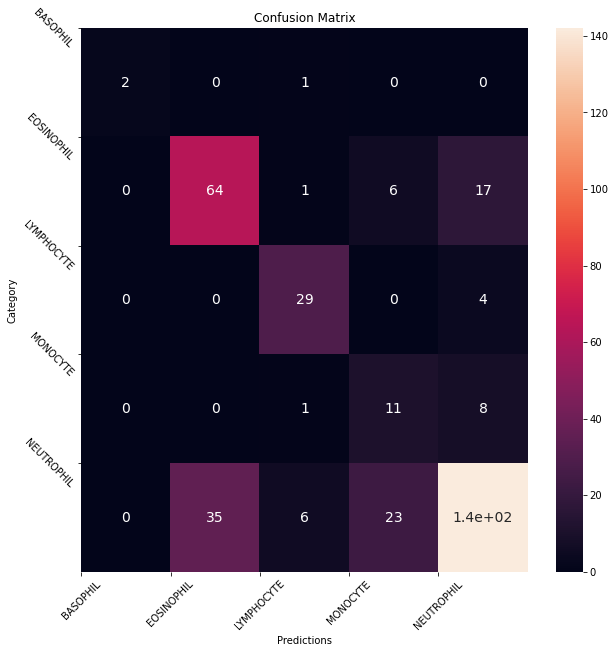

In [71]:
conf_matrix = confusion_matrix(df["Category"], df["Predictions"])
labels = list(pd.concat([df["Category"], df["Predictions"]]).unique())
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 14}, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predictions")
ax.set_ylabel("Category")
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.xaxis.set_ticklabels(sorted(labels), rotation=45)
ax.yaxis.set_ticklabels(sorted(labels), rotation=-45)
plt.show()


# Conclusion

The baseline of the model is an accuracy of 58.9%. This would happen if the classifier were to predict every image as being a neutrophil (most frequent class in the dataset). Since the model developed performed better than the baseline established, one could assume the results obtained are satisfying. On the other hand, an accuracy of 70.86% is not good for real life usage. Some future work could be done to improve the performance of the model and perhaps the usage of CNNs could boost the accuracy enough for it to be considered production ready. 